### Tuning layer size for HinSAGE

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_curve, auc, precision_recall_curve
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut 

layer_size_1=[16,32,64]
layer_size_2=[32,64,128,256]

# Change the following variables according to your needs
species = 'human'
tissue = 'heart'

esslnc_path = f'../../data/benchmark/{species}/ess_lpi.csv'  
nonesslnc_path = f'../../data/benchmark/{species}/noness_lpi.csv'  

esslnc = pd.read_csv(esslnc_path)  
nonesslnc = pd.read_csv(nonesslnc_path)

esslnc_id = set(esslnc['lncRNA_ID'])
nonesslnc_id = set(nonesslnc['lncRNA_ID'])

metrics_df = pd.DataFrame()  # DataFrame to store metrics for each configuration

for i in layer_size_1:
    for j in layer_size_2:

        # File paths
        lncRNA_path = f'../../HinSAGE/{species}/layer_size/lncRNA_embeddings_{tissue}_{i}_{j}.csv'
        lnc = pd.read_csv(lncRNA_path, index_col=0, header=None)  

        lnc_ess = lnc[lnc.index.isin(esslnc_id)]
        lnc_noness = lnc[lnc.index.isin(nonesslnc_id)]

        # Prepare data arrays
        X_positive = lnc_ess.values
        X_negative = lnc_noness.values
        ids_positive = lnc_ess.index
        ids_negative = lnc_noness.index

        # Combine datasets
        X_all = np.vstack((X_positive, X_negative))
        y_all = np.hstack((np.ones(len(X_positive)), np.zeros(len(X_negative))))
        ids_all = np.hstack((ids_positive, ids_negative))

        # Prepare DataFrame to save experimental records
        experiment_records = pd.DataFrame()

        # Initialize lists to store all true labels and decision scores
        all_true_labels = []
        all_decision_scores = []

        if species == 'mouse':
            cv = LeaveOneOut() 
        else:
            cv = KFold(n_splits=10, shuffle=True, random_state=42)

        for fold, (train_index, test_index) in enumerate(cv.split(X_all)):
            X_train, X_test = X_all[train_index], X_all[test_index]
            y_train, y_test = y_all[train_index], y_all[test_index]
            ids_train, ids_test = ids_all[train_index], ids_all[test_index]

            # Apply MinMaxScaler
            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            svm = LinearSVC(C=10, dual=False)
            svm.fit(X_train_scaled, y_train)

            decision_scores = svm.decision_function(X_test_scaled)
            predictions = (decision_scores >= 0).astype(int)

            fold_data = {
                'Fold': fold + 1,
                'Train_IDs': [list(ids_train)],
                'Train_Labels': [list(y_train)],
                'Test_IDs': [list(ids_test)],
                'Test_Labels': [list(y_test)],
                'Predictions': [list(predictions)],
                'Decision_Scores': [list(decision_scores)]
            }
            fold_df = pd.DataFrame(fold_data)
            experiment_records = pd.concat([experiment_records, fold_df], ignore_index=True)

            all_true_labels.extend(y_test)
            all_decision_scores.extend(decision_scores)

        # Convert lists to arrays for performance evaluation
        all_true_labels = np.array(all_true_labels)
        all_decision_scores = np.array(all_decision_scores)

        # Compute confusion matrix using threshold at 0
        tn, fp, fn, tp = confusion_matrix(all_true_labels, (all_decision_scores >= 0).astype(int)).ravel()

        # Compute performance metrics
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1_score = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0
        mcc = matthews_corrcoef(all_true_labels, (all_decision_scores >= 0).astype(int))

        experiment_records.to_csv(f'./experiment_details/{species}/hinsage_layersize_{tissue}_experiment_details_{i}_{j}.csv', index=False)

        # Compute and save ROC curve data
        fpr, tpr, _ = roc_curve(all_true_labels, all_decision_scores)
        roc_auc = auc(fpr, tpr)

        # Compute and save Precision-Recall curve data
        precision, recall, _ = precision_recall_curve(all_true_labels, all_decision_scores)
        pr_auc = auc(recall, precision)

        metrics = {
            'layer_size_1': i,
            'layer_size_2': j,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV': ppv,
            'F1 Score': f1_score,
            'Accuracy': accuracy,
            'MCC': mcc,
            'ROC AUC': roc_auc,
            'PR AUC': pr_auc
        }
        new_row = pd.DataFrame([metrics])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

# Save metrics DataFrame to CSV
metrics_df.to_csv(f'./performance/{species}/hinsage_layersize_{tissue}_metrics.csv', index=False)

### Tuning samples numbers for HinSAGE

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_curve, auc, precision_recall_curve
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut 

samples_num_1=[5,10,15,20]
samples_num_2=[10,15,20,25]

# Change the following variables according to your needs
species = 'human'
tissue = 'heart'

esslnc_path = f'../../data/benchmark/{species}/ess_lpi.csv'  
nonesslnc_path = f'../../data/benchmark/{species}/noness_lpi.csv'  

esslnc = pd.read_csv(esslnc_path)  
nonesslnc = pd.read_csv(nonesslnc_path)

esslnc_id = set(esslnc['lncRNA_ID'])
nonesslnc_id = set(nonesslnc['lncRNA_ID'])

metrics_df = pd.DataFrame()  # DataFrame to store metrics for each configuration

for i in samples_num_1:
    for j in samples_num_2:

        # File paths
        lncRNA_path = f'../../HinSAGE/{species}/samples_num/lncRNA_embeddings_heart_{i}_{j}.csv'
        lnc = pd.read_csv(lncRNA_path, index_col=0, header=None)  

        lnc_ess = lnc[lnc.index.isin(esslnc_id)]
        lnc_noness = lnc[lnc.index.isin(nonesslnc_id)]

        # Prepare data arrays
        X_positive = lnc_ess.values
        X_negative = lnc_noness.values
        ids_positive = lnc_ess.index
        ids_negative = lnc_noness.index

        # Combine datasets
        X_all = np.vstack((X_positive, X_negative))
        y_all = np.hstack((np.ones(len(X_positive)), np.zeros(len(X_negative))))
        ids_all = np.hstack((ids_positive, ids_negative))

        # Prepare DataFrame to save experimental records
        experiment_records = pd.DataFrame()

        # Initialize lists to store all true labels and decision scores
        all_true_labels = []
        all_decision_scores = []

        if species == 'mouse':
            cv = LeaveOneOut() 
        else:
            cv = KFold(n_splits=10, shuffle=True, random_state=42)

        for fold, (train_index, test_index) in enumerate(cv.split(X_all)):
            X_train, X_test = X_all[train_index], X_all[test_index]
            y_train, y_test = y_all[train_index], y_all[test_index]
            ids_train, ids_test = ids_all[train_index], ids_all[test_index]

            # Apply MinMaxScaler
            scaler = MinMaxScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            svm = LinearSVC(C=10, dual=False)
            svm.fit(X_train_scaled, y_train)

            decision_scores = svm.decision_function(X_test_scaled)
            predictions = (decision_scores >= 0).astype(int)

            fold_data = {
                'Fold': fold + 1,
                'Train_IDs': [list(ids_train)],
                'Train_Labels': [list(y_train)],
                'Test_IDs': [list(ids_test)],
                'Test_Labels': [list(y_test)],
                'Predictions': [list(predictions)],
                'Decision_Scores': [list(decision_scores)]
            }
            fold_df = pd.DataFrame(fold_data)
            experiment_records = pd.concat([experiment_records, fold_df], ignore_index=True)

            all_true_labels.extend(y_test)
            all_decision_scores.extend(decision_scores)

        # Convert lists to arrays for performance evaluation
        all_true_labels = np.array(all_true_labels)
        all_decision_scores = np.array(all_decision_scores)

        # Compute confusion matrix using threshold at 0
        tn, fp, fn, tp = confusion_matrix(all_true_labels, (all_decision_scores >= 0).astype(int)).ravel()

        # Compute performance metrics
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        f1_score = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0
        mcc = matthews_corrcoef(all_true_labels, (all_decision_scores >= 0).astype(int))

        experiment_records.to_csv(f'./experiment_details/{species}/hinsage_samplesnum_{tissue}_experiment_details_{i}_{j}.csv', index=False)

        # Compute and save ROC curve data
        fpr, tpr, _ = roc_curve(all_true_labels, all_decision_scores)
        roc_auc = auc(fpr, tpr)

        # Compute and save Precision-Recall curve data
        precision, recall, _ = precision_recall_curve(all_true_labels, all_decision_scores)
        pr_auc = auc(recall, precision)

        metrics = {
            'samples_num_1': i,
            'samples_num_2': j,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'PPV': ppv,
            'F1 Score': f1_score,
            'Accuracy': accuracy,
            'MCC': mcc,
            'ROC AUC': roc_auc,
            'PR AUC': pr_auc
        }
        new_row = pd.DataFrame([metrics])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

# Save metrics DataFrame to CSV
metrics_df.to_csv(f'./performance/{species}/hinsage_samplesnum_{tissue}_metrics.csv', index=False)

### Tune C for linearSVM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_curve, auc, precision_recall_curve
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

# Change the following variables according to your needs
species = 'human'
tissue = 'heart'

esslnc_path = f'../../data/benchmark/{species}/ess_lpi.csv'  
nonesslnc_path = f'../../data/benchmark/{species}/noness_lpi.csv'  
lncRNA_path = f'../../HinSAGE/{species}/lncRNA_embeddings_{tissue}.csv'

# Reading the data
lnc = pd.read_csv(lncRNA_path, index_col=0, header=None)
esslnc = pd.read_csv(esslnc_path)
nonesslnc = pd.read_csv(nonesslnc_path)

esslnc_id = set(esslnc['lncRNA_ID'])
nonesslnc_id = set(nonesslnc['lncRNA_ID'])

lnc_ess = lnc[lnc.index.isin(esslnc_id)]
lnc_noness = lnc[lnc.index.isin(nonesslnc_id)]

# Prepare data arrays
X_positive = lnc_ess.values
X_negative = lnc_noness.values
ids_positive = lnc_ess.index
ids_negative = lnc_noness.index

# Combine datasets
X_all = np.vstack((X_positive, X_negative))
y_all = np.hstack((np.ones(len(X_positive)), np.zeros(len(X_negative))))
ids_all = np.hstack((ids_positive, ids_negative))

# Define the values of 'C' to test
C_values = [1, 10, 100]

# Prepare to store results
results = []

# Initialize cross-validation
if species == 'mouse':
    cv = LeaveOneOut() 
else:
    cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Iterate over each value of C
for C in C_values:
    all_true_labels = []
    all_decision_scores = []
    # Prepare DataFrame to save experimental records
    experiment_records = pd.DataFrame()

    for fold, (train_index, test_index) in enumerate(cv.split(X_all)):
        X_train, X_test = X_all[train_index], X_all[test_index]
        y_train, y_test = y_all[train_index], y_all[test_index]
        ids_train, ids_test = ids_all[train_index], ids_all[test_index]

        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        svm = LinearSVC(C=C, dual=False)
        svm.fit(X_train_scaled, y_train)
        decision_scores = svm.decision_function(X_test_scaled)
        predictions = (decision_scores >= 0).astype(int)

        all_true_labels.extend(y_test)
        all_decision_scores.extend(decision_scores)
        
        fold_data = {
            'Fold': fold + 1,
            'Train_IDs': [list(ids_train)],
            'Train_Labels': [list(y_train)],
            'Test_IDs': [list(ids_test)],
            'Test_Labels': [list(y_test)],
            'Predictions': [list(predictions)],
            'Decision_Scores': [list(decision_scores)]
        }
        fold_df = pd.DataFrame(fold_data)
        experiment_records = pd.concat([experiment_records, fold_df], ignore_index=True)

    all_true_labels = np.array(all_true_labels)
    all_decision_scores = np.array(all_decision_scores)
    y_pred = (all_decision_scores >= 0).astype(int)

    tn, fp, fn, tp = confusion_matrix(all_true_labels, y_pred).ravel()

    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    f1 = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0
    mcc = matthews_corrcoef(all_true_labels, y_pred)

    fpr, tpr, _ = roc_curve(all_true_labels, all_decision_scores)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(all_true_labels, all_decision_scores)
    pr_auc = auc(recall, precision)

    results.append({
        'C': C,
        'Precision': ppv,
        'Recall': sensitivity,
        'Specificity': specificity,
        'F1': f1,
        'Accuracy': accuracy,
        'MCC': mcc,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc
    })
    experiment_records.to_csv(f'./experiment_details/{species}/svm_C_experiment_details_{C}.csv', index=False)

# Save all results to a CSV
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Precision', ascending=False)
results_df.to_csv(f'./performance/{species}/svm_C_HinSAGE.csv', index=False)

# Output best C
best_row = results_df.iloc[0]
print("Best SVM parameters based on Precision (PPV):")
print(f"Best C: {best_row['C']}")
print(f"Best PPV: {best_row['Precision']:.4f}")
print(f"Best MCC: {best_row['MCC']:.4f}")


Best SVM parameters based on Precision (PPV):
Best C: 10.0
Best PPV: 0.8686
Best MCC: 0.7074


### cross validition

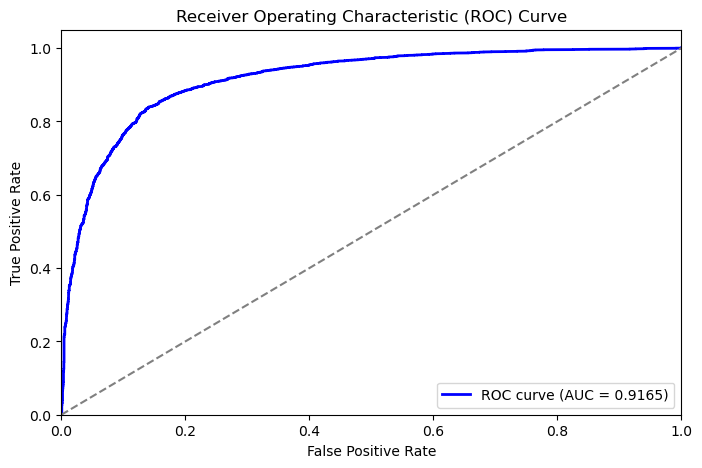

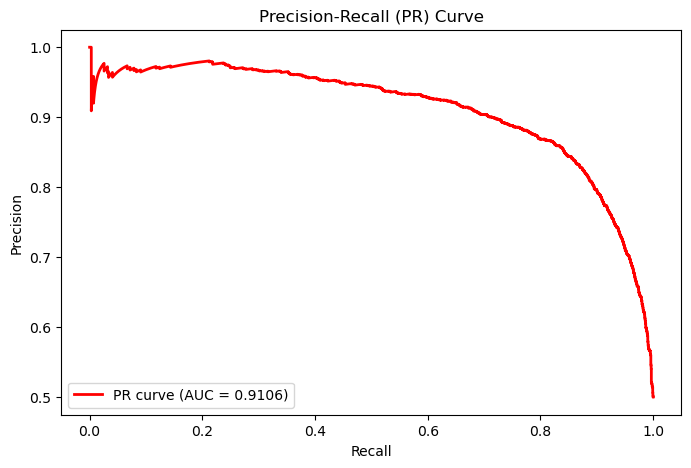

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut 
import os

species = 'human'
tissue = 'stomach'

# File paths
esslnc_path = f'../../data/benchmark/{species}/ess_lpi.csv'
nonesslnc_path = f'../../data/benchmark/{species}/noness_lpi.csv'

lncRNA_path = f'../../HinSAGE/{species}/lncRNA_embeddings_{tissue}.csv'

lnc = pd.read_csv(lncRNA_path, index_col=0, header=None)  

esslnc = pd.read_csv(esslnc_path)  
nonesslnc = pd.read_csv(nonesslnc_path)

esslnc_id = set(esslnc['lncRNA_ID'])
nonesslnc_id = set(nonesslnc['lncRNA_ID'])

lnc_ess = lnc[lnc.index.isin(esslnc_id)]
lnc_noness = lnc[lnc.index.isin(nonesslnc_id)]

# Prepare data arrays
X_positive = lnc_ess.values
X_negative = lnc_noness.values
ids_positive = lnc_ess.index
ids_negative = lnc_noness.index

# Combine datasets
X_all = np.vstack((X_positive, X_negative))
y_all = np.hstack((np.ones(len(X_positive)), np.zeros(len(X_negative))))
ids_all = np.hstack((ids_positive, ids_negative))

# Initialize cross-validation
if species == 'mouse':
    cv = LeaveOneOut() 
    C = 10
else:
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    C = 10

# Prepare DataFrame to save experimental records
experiment_records = pd.DataFrame()
roc_data = []
pr_data = []

# Initialize lists to store all true labels and decision scores
all_true_labels = []
all_decision_scores = []

# cross-validation
for fold, (train_index, test_index) in enumerate(cv.split(X_all)):
    X_train, X_test = X_all[train_index], X_all[test_index]
    y_train, y_test = y_all[train_index], y_all[test_index]
    ids_train, ids_test = ids_all[train_index], ids_all[test_index]
    
    # Apply MinMaxScaler
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    svm = LinearSVC(C=C, dual=False) 
    
    svm.fit(X_train_scaled, y_train)

    decision_scores = svm.decision_function(X_test_scaled)
    predictions = (decision_scores >= 0).astype(int)

    fold_data = {
        'Fold': fold + 1,
        'Train_IDs': [list(ids_train)],
        'Train_Labels': [list(y_train)],
        'Test_IDs': [list(ids_test)],
        'Test_Labels': [list(y_test)],
        'Predictions': [list(predictions)],
        'Decision_Scores': [list(decision_scores)]
    }
    fold_df = pd.DataFrame(fold_data)
    experiment_records = pd.concat([experiment_records, fold_df], ignore_index=True)
    
    all_true_labels.extend(y_test)
    all_decision_scores.extend(decision_scores)

# Convert lists to arrays for performance evaluation
all_true_labels = np.array(all_true_labels)
all_decision_scores = np.array(all_decision_scores)

# Compute confusion matrix using threshold at 0
tn, fp, fn, tp = confusion_matrix(all_true_labels, (all_decision_scores >= 0).astype(int)).ravel()

# Compute performance metrics
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1_score = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0
mcc = matthews_corrcoef(all_true_labels, (all_decision_scores >= 0).astype(int))

experiment_records.to_csv(f'./experiment_details/{species}/svm_{tissue}_ELGP(HinSAGE)_experiment_details.csv', index=False)

# Compute and save ROC curve data
fpr, tpr, _ = roc_curve(all_true_labels, all_decision_scores)
roc_auc = auc(fpr, tpr)
roc_data.append(pd.DataFrame({'FPR': fpr, 'TPR': tpr}))

# Compute and save Precision-Recall curve data
precision, recall, _ = precision_recall_curve(all_true_labels, all_decision_scores)
pr_auc = auc(recall, precision)
pr_data.append(pd.DataFrame({'Recall': recall, 'Precision': precision}))

metrics_row = {
    'Model': 'SVM',
    'Tissue': f'{tissue}',
    'Features': 'ELGP(HinSAGE)',
    'Sensitivity(Recall)': sensitivity,
    'Specificity': specificity,
    'PPV(Precision)': ppv,
    'F1_Score': f1_score,
    'Accuracy': accuracy,
    'MCC': mcc,
    'ROC_AUC': roc_auc,
    'PR_AUC': pr_auc
}

metrics_df = pd.DataFrame([metrics_row])

metrics_output_path = f'./performance/{species}/svm_{tissue}_summary.csv'
os.makedirs(os.path.dirname(metrics_output_path), exist_ok=True)

if os.path.exists(metrics_output_path):
    metrics_df.to_csv(metrics_output_path, mode='a', header=False, index=False)
else:
    metrics_df.to_csv(metrics_output_path, mode='w', header=True, index=False)

roc_data[0].to_csv(f'./performance/{species}/curve/roc_curve_{tissue}_ELGP(HinSAGE).csv', index=False)
pr_data[0].to_csv(f'./performance/{species}/curve/pr_curve_{tissue}_ELGP(HinSAGE).csv', index=False)

# Plot ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, color='red', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend(loc='lower left')
plt.show()


### Predict step

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

species = 'human'
tissue = 'stomach'

if species == 'mouse':
	C = 10
else:
	C = 10

# File paths
esslnc_path = f'../../data/benchmark/{species}/ess_lpi.csv'
nonesslnc_path = f'../../data/benchmark/{species}/noness_lpi.csv'

esslnc = pd.read_csv(esslnc_path)  
nonesslnc = pd.read_csv(nonesslnc_path)

esslnc_id = set(esslnc['lncRNA_ID'])
nonesslnc_id = set(nonesslnc['lncRNA_ID'])

all_samples_path = f'../../HinSAGE/{species}/lncRNA_embeddings_{tissue}.csv'
all_lnc = pd.read_csv(all_samples_path, index_col=0, header=None)

lnc_ess = all_lnc[all_lnc.index.isin(esslnc_id)]
lnc_noness = all_lnc[all_lnc.index.isin(nonesslnc_id)]

# Prepare training data
X_positive = lnc_ess.values
X_negative = lnc_noness.values

# Apply MinMaxScaler
scaler = MinMaxScaler()

X_train = np.vstack((X_positive, X_negative))
X_train_scaled = scaler.fit_transform(X_train)
y_train = np.hstack((np.ones(len(X_positive)), np.zeros(len(X_negative))))

# Train SVM model
svm = LinearSVC(C=C, dual=False)
svm.fit(X_train_scaled, y_train)

# Score and predict for all data
X_all = all_lnc.values
X_all_scaled = scaler.transform(X_all)
ids_all = all_lnc.index

scores = svm.decision_function(X_all_scaled)
labels = np.where(scores > 0, 1, 0)

# Generate results DataFrame
results_df = pd.DataFrame({'lncRNA_ID': ids_all, 'Score': scores, 'Pre_Label': labels})

# Save results to CSV file
results_df.to_csv(f'../../results/{species}/SVM_predictions_{tissue}.csv', index=False)

